# Assigning Geometric Properties

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import openpnm as op

Let's start by creating a blank Cubic network.  As we can see by printing it, there only coordinates, connections, and some labels, but no geometric properties:

In [14]:
pn = op.network.Cubic([20, 20, 20], spacing=5e-5)
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x287d17c4b80>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.coords                                                   8000 / 8000
  2  throat.conns                                                22800 / 22800
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.back                                                             400
  2  pore.bottom                                                           400
  3  pore.front                                                            400
  4 

> In OpenPNM V3 we have removed the concept of ``Geometry`` and ``Physics`` objects, in favor of placing all the properties on the ``Network`` and ``Phase`` objects instead. 

To add geometrical properties to a network, we have a few different options.  Each will be explored below:

## Manually Calculating Properties

> This is not the preferred way to do things, but does illustrate the processes very well. The preferred way is using pore-scale models, which allow for the automatic regeneration of dependent properities when something changes. 

Let's start by adding pore and throat size distributions.  There are a few different ways to do this, and we'll explore each one just to be thorough.  

### Adding pore and throat sizes from `scipy.stats` distributions

Scipy's `stats` module has a *lot* of statistical distributions defined.  Let's generate pore and throat sizes using some of these.  First, let's use a normal distribution to generate pore sizes within the range ~1 to 50 um:

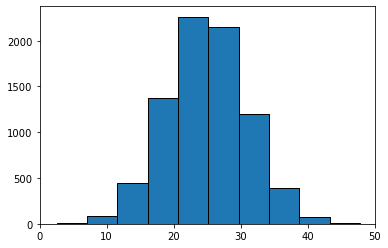

In [24]:
np.random.seed(0)
import scipy.stats as spst
psd = spst.norm.rvs(loc=25, scale=6, size=pn.Np)
plt.hist(psd, edgecolor='k')
plt.xlim([0, 50]);

Let's just make sure that our distribution is not so wide that it has negative numbers or values greater than 50 um:

In [26]:
print(psd.min())
print(psd.max())

2.5593961722893255
47.80996128980269


Now we'll convert these values to SI and assign to the network:

In [27]:
pn['pore.diameter'] = psd*1e-6

Next we need to define throat diameters. We can do this in the same way, but let's use a different distribution.  Note that this approach is not recommended because as we'll see it results in throats that are larger than the two pores they are connected two.  We'll fix this in the following section:

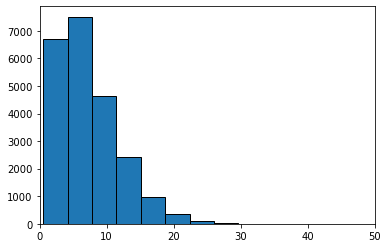

In [53]:
np.random.seed(0)
tsd = spst.weibull_min.rvs(c=1.5, loc=.5, scale=7.5, size=pn.Nt)
plt.hist(tsd, edgecolor='k')
plt.xlim([0, 50]);

In [54]:
print(tsd.min())
print(tsd.max())

0.5130345457395142
36.96861960231873


So we can see that we have throats as small as 500 nm, and as large as 37 um.  These can be assigned to the network as well:

In [68]:
pn['throat.diameter'] = tsd*1e-6

The problem with this approach is that both pore and throat sizes were just assigned to random locations, rather than putting small throats between small pores and vice-versa. When throats are larger than the pores they connect it can cause problems or strageness in the results since we generally assume a throat is a constriction between two pores.  Let's count how many are problematic.

In [72]:
hits = np.any(pn['pore.diameter'][pn.conns].T < pn['throat.diameter'], axis=0)

In [71]:
hits.sum()

564

> 💡 **ProTip! - Indexing pore properties by `conns`**
> 
> Using the ``conns`` array to index into a pore property returns an Nt-by-2 array with the properties of the pores on the end of a throat in each column.  For instance, so see the diameter of the pore on each end of a throat, use ``pn['pore.diameter'][pn.conns]``.  This approach is very powerful.  If you ever feel tempted to use a for-loop to scan over each pore, then inspect the properties of the neighboring throats, consider instead if you can "loop" over the throats then interogate each pore.  If yes, then you can use this conns-indexing trick.

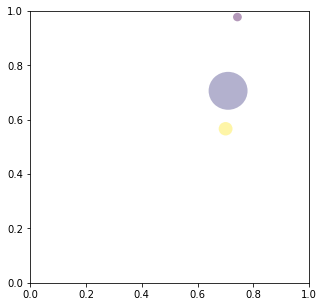

In [78]:
import numpy as np
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)


fig, ax = plt.subplots(figsize=[5, 5])

resolution = 50  # the number of vertices
N = 3
x = np.random.rand(N)
y = np.random.rand(N)
radii = 0.1*np.random.rand(N)
patches = []
for x1, y1, r in zip(x, y, radii):
    circle = Circle((x1, y1), r)
    patches.append(circle)
colors = 100 * np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.4)
p.set_array(colors)
ax.add_collection(p)
